# Creating Knowledge graphs from Pdf files

In [101]:
from langchain.graphs import Neo4jGraph

url = ""
username =""
password = ""
graph = Neo4jGraph(
    url=url,
    username=username,
    password=password
)

In [102]:
import os
from dotenv import load_dotenv 
from langchain_community.graphs.graph_document import (
    Node as BaseNode,
    Relationship as BaseRelationship,
    GraphDocument,
)
from langchain.schema import Document
from typing import List, Dict, Any, Optional
from langchain.pydantic_v1 import Field, BaseModel

load_dotenv()

# Add OpenAI key
#os.environ['OPENAI_API_KEY']=''
api_key = os.environ['OPENAI_API_KEY']

class Property(BaseModel):
  """A single property consisting of key and value"""
  key: str = Field(..., description="key")
  value: str = Field(..., description="value")

class Node(BaseNode):
    properties: Optional[List[Property]] = Field(
        None, description="List of node properties")

class Relationship(BaseRelationship):
    properties: Optional[List[Property]] = Field(
        None, description="List of relationship properties"
    )

# class Source(BaseSource):
#     properties: Optional[List[Property]] = Field(
#         None, description="List of sources"
#     )        
        
class KnowledgeGraph(BaseModel):
    """Generate a knowledge graph with entities and relationships."""
    nodes: List[Node] = Field(
        ..., description="List of nodes in the knowledge graph")
    rels: List[Relationship] = Field(
        ..., description="List of relationships in the knowledge graph"
    )
    
def format_property_key(s: str) -> str:
    words = s.split()
    if not words:
        return s
    first_word = words[0].lower()
    capitalized_words = [word.capitalize() for word in words[1:]]
    return "".join([first_word] + capitalized_words)

def props_to_dict(props) -> dict:
    """Convert properties to a dictionary."""
    properties = {}
    if not props:
      return properties
    for p in props:
        properties[format_property_key(p.key)] = p.value
    return properties

def map_to_base_node(node: Node) -> BaseNode:
    """Map the KnowledgeGraph Node to the base Node."""
    properties = props_to_dict(node.properties) if node.properties else {}
    # Add name property for better Cypher statement generation
    properties["name"] = node.id.title()
    return BaseNode(
        id=node.id.title(), type=node.type.capitalize(), properties=properties
    )


def map_to_base_relationship(rel: Relationship) -> BaseRelationship:
    """Map the KnowledgeGraph Relationship to the base Relationship."""
    source = map_to_base_node(rel.source)
    target = map_to_base_node(rel.target)
    properties = props_to_dict(rel.properties) if rel.properties else {}
    return BaseRelationship(
        source=source, target=target, type=rel.type, properties=properties
    )    


# Using GPT-3.5-turbo-16k model to create the knowledge graph

In [103]:
import os
from langchain.chains.openai_functions import (
    create_openai_fn_chain,
    create_structured_output_chain,
)
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate

# os.environ["OPENAI_API_KEY"] = "sk-"
llm = ChatOpenAI(model="gpt-3.5-turbo-16k", temperature=0)

def get_extraction_chain(
    input,
    allowed_nodes: Optional[List[str]] = None,
    allowed_rels: Optional[List[str]] = None
    ):
    prompt = ChatPromptTemplate.from_messages(
        [(
          "system",
          f"""# Knowledge Graph Instructions for GPT-3.5
## 1. Overview
You are a top-tier algorithm designed for extracting information in structured formats to build a knowledge graph.
- **Nodes** represent entities and concepts. They're akin to Wikipedia nodes.
- The aim is to achieve simplicity and clarity in the knowledge graph, making it accessible for a vast audience.
## 2. Labeling Nodes
- **Consistency**: Ensure you use basic or elementary types for node labels.
  - For example, when you identify an entity representing a person, always label it as **"person"**. Avoid using more specific terms like "mathematician" or "scientist".
- **Node IDs**: Never utilize integers as node IDs. Node IDs should be names or human-readable identifiers found in the text.
{'- **Allowed Node Labels:**' + ", ".join(allowed_nodes) if allowed_nodes else ""}
{'- **Allowed Relationship Types**:' + ", ".join(allowed_rels) if allowed_rels else ""}
## 3. Handling Numerical Data and Dates
- Numerical data, like age or other related information, should be incorporated as attributes or properties of the respective nodes.
- **No Separate Nodes for Dates/Numbers**: Do not create separate nodes for dates or numerical values. Always attach them as attributes or properties of nodes.
- **Property Format**: Properties must be in a key-value format.
- **Quotation Marks**: Never use escaped single or double quotes within property values.
- **Naming Convention**: Use camelCase for property keys, e.g., `birthDate`.
## 4. Coreference Resolution
- **Maintain Entity Consistency**: When extracting entities, it's vital to ensure consistency.
If an entity, such as "John Doe", is mentioned multiple times in the text but is referred to by different names or pronouns (e.g., "Joe", "he"),
always use the most complete identifier for that entity throughout the knowledge graph. In this example, use "John Doe" as the entity ID.
Remember, the knowledge graph should be coherent and easily understandable, so maintaining consistency in entity references is crucial.
## 5. Strict Compliance
Adhere to the rules strictly. Non-compliance will result in termination.
          """),
            ("human", "Use the given format to extract information from the following input: {input}"),
            ("human", "Tip: Make sure to answer in the correct format"),
        ])
    return create_structured_output_chain(KnowledgeGraph, llm, prompt, verbose=False)

In [104]:
import threading
import time

def extract_and_store_graph(
    document: Document,
    nodes:Optional[List[str]] = None,
    rels:Optional[List[str]]=None) -> None:
    # Extract graph data using OpenAI functions
    extract_chain = get_extraction_chain(document.page_content,nodes, rels)
    data = extract_chain.invoke(document.page_content)['function']
    # Construct a graph document
    graph_document = GraphDocument(
      nodes = [map_to_base_node(node) for node in data.nodes],
      relationships = [map_to_base_relationship(rel) for rel in data.rels],
      source = document
    )
    # Store information into a graph
    graph.add_graph_documents([graph_document])
    return graph_document

In [105]:
import re
import unicodedata 

def filter_text(text):
    # regex pattern to match ascii characters and currency symbols
    pattern = re.compile(r'[^\x20-\x7E\u20A0-\u20CF\u20E0-\u20FF]')
    # Use the pattern to filter out non-English characters
    filtered_text = re.sub(pattern, '', text)
    
    return filtered_text

In [106]:

from langchain.text_splitter import TokenTextSplitter

from langchain_community.document_loaders import PyPDFLoader

from datetime import datetime


loader = PyPDFLoader("../data/new_york_city_example_itinerary.pdf")

pages = loader.load()

for page in pages:
    page.page_content = filter_text(page.page_content)
# Define chunking strategy
text_splitter = TokenTextSplitter(chunk_size=200, chunk_overlap=20)

# Only take the first 4 pages of the document
documents = text_splitter.split_documents(pages)

In [90]:
len(documents)

15

Replacing currency symbols with respective unicode

In [ ]:
for doc in documents:
        currency_symbol = None  
        for char in doc.page_content:  
                if unicodedata.category(char) == "Sc":  
                        currency_symbol = char  
                        break  
        # Convert the currency symbol to a Unicode escape sequence  
        if currency_symbol is not None:  
                encoded_symbol = "\\u" + hex(ord(currency_symbol))[2:].zfill(4)  
                doc.page_content = doc.page_content.replace(currency_symbol, encoded_symbol)  
                print(doc.page_content)

In [108]:
def get_nodes_and_relations_count(graph_document_list: List[GraphDocument]):
    distinct_nodes = set()
    relations = []

    for graph_document in graph_document_list:
        #get distinct nodes
        for node in graph_document.nodes:
                node_id = node.id
                node_type= node.type
                if (node_id, node_type) not in distinct_nodes:
                    distinct_nodes.add((node_id, node_type))
        #get all relations
        for relation in graph_document.relationships:
                relations.append(relation.type)
            
    print("nodes = ",len(distinct_nodes))   
    print("relations = ",len(relations)) 

Sequencial Processing of chunks (chunk size 200)

In [67]:
from tqdm import tqdm

distinct_nodes = set()
relations = []
graph_document_list=[]
start_time = datetime.now()

for i, d in tqdm(enumerate(documents), total=len(documents)):
    graph_document=extract_and_store_graph(d)

    graph_document_list.append(graph_document)

end_time = datetime.now()  
print("Processing_time = ", end_time-start_time) 
get_nodes_and_relations_count(graph_document_list) 

100%|██████████| 15/15 [03:20<00:00, 13.33s/it]

Processing_time =  0:03:20.005178
nodes =  108
relations =  107


Parallel Processing chunk with ThreadPool size 8 (chunk size 200)

In [78]:
from tqdm import tqdm
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor

graph_document_list=[]
futures=[]
start_time = datetime.now()
with ThreadPoolExecutor(max_workers=8) as executor:
    
    for i,chunk in tqdm(enumerate(documents), total=len(documents)):
        futures.append(executor.submit(extract_and_store_graph,chunk))
    
    for future in concurrent.futures.as_completed(futures):
        graph_document_list.append(future.result())
    
end_time = datetime.now()  
print("Processing_time = ", end_time-start_time) 
get_nodes_and_relations_count(graph_document_list) 

100%|██████████| 15/15 [00:00<00:00, 168.07it/s]


Processing_time =  0:00:28.000194
nodes =  108
relations =  101


Combined 2 chunks and sequential processing

In [81]:
from tqdm import tqdm

graph_document_list=[]
futures=[]
combined_chunk=''
combined_chunk_document_list=[]
   
combined_chunks = ["".join(document.page_content for document in documents[i:i+2]) for i in range(0, len(documents),2)]

for i in range(len(combined_chunks)):
        combined_chunk_document_list.append(Document(page_content=combined_chunks[i]))       
        
start_time = datetime.now()
     
for i, d in tqdm(enumerate(combined_chunk_document_list), total=len(combined_chunk_document_list)):
    graph_document=extract_and_store_graph(d)
    graph_document_list.append(graph_document)
        
end_time = datetime.now()  
print("Processing_time = ", end_time-start_time) 
get_nodes_and_relations_count(graph_document_list)         

100%|██████████| 8/8 [01:41<00:00, 12.65s/it]

Processing_time =  0:01:41.191927
nodes =  76
relations =  52


Combined 2 chunks and Parallel processing

In [93]:
from tqdm import tqdm
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor

graph_document_list=[]
futures=[]
combined_chunk=''
combined_chunk_document_list=[]
   
combined_chunks = ["".join(document.page_content for document in documents[i:i+2]) for i in range(0, len(documents),2)]

start_time = datetime.now()
     
with ThreadPoolExecutor(max_workers=10) as executor:
    for i in range(len(combined_chunks)):
        combined_chunk_document_list.append(Document(page_content=combined_chunks[i]))
 
    for i,chunk in tqdm(enumerate(combined_chunk_document_list), total=len(combined_chunk_document_list)):
        futures.append(executor.submit(extract_and_store_graph,chunk))
    
    for future in concurrent.futures.as_completed(futures):
        graph_document_list.append(future.result())
        
end_time = datetime.now()  
print("Processing_time = ", end_time-start_time) 
get_nodes_and_relations_count(graph_document_list)         

100%|██████████| 8/8 [00:00<00:00, 72.09it/s]


Processing_time =  0:00:41.756752
nodes =  77
relations =  54


In [109]:
loader = PyPDFLoader("../data/new_york_city_example_itinerary.pdf")
pages = loader.load()
for page in pages:
    page.page_content = filter_text(page.page_content)
# Define chunking strategy
text_splitter = TokenTextSplitter(chunk_size=500, chunk_overlap=20)

documents = text_splitter.split_documents(pages)

In [110]:
len(documents)

7

Sequential processing of chunk (Chunk size 500)

In [99]:
from tqdm import tqdm

distinct_nodes = set()
relations = []
graph_document_list=[]
start_time = datetime.now()

for i, d in tqdm(enumerate(documents), total=len(documents)):
    graph_document=extract_and_store_graph(d)

    graph_document_list.append(graph_document)

end_time = datetime.now()  
print("Processing_time = ", end_time-start_time) 
get_nodes_and_relations_count(graph_document_list) 

100%|██████████| 7/7 [01:53<00:00, 16.18s/it]

Processing_time =  0:01:53.235920
nodes =  71
relations =  69


Parallel Processing chunk with ThreadPool size 8 (chunk size 500)

In [111]:
from tqdm import tqdm
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor

graph_document_list=[]
futures=[]
start_time = datetime.now()
with ThreadPoolExecutor(max_workers=8) as executor:
    
    for i,chunk in tqdm(enumerate(documents), total=len(documents)):
        futures.append(executor.submit(extract_and_store_graph,chunk))
    
    for future in concurrent.futures.as_completed(futures):
        graph_document_list.append(future.result())
    
end_time = datetime.now()  
print("Processing_time = ", end_time-start_time) 
get_nodes_and_relations_count(graph_document_list) 

100%|██████████| 7/7 [00:00<00:00, 132.89it/s]


Processing_time =  0:00:25.987004
nodes =  70
relations =  59


Combined 2 chunks and sequential processing

In [112]:
from tqdm import tqdm

graph_document_list=[]
futures=[]
combined_chunk=''
combined_chunk_document_list=[]
   
combined_chunks = ["".join(document.page_content for document in documents[i:i+2]) for i in range(0, len(documents),2)]

for i in range(len(combined_chunks)):
        combined_chunk_document_list.append(Document(page_content=combined_chunks[i]))       
        
start_time = datetime.now()
     
for i, d in tqdm(enumerate(combined_chunk_document_list), total=len(combined_chunk_document_list)):
    graph_document=extract_and_store_graph(d)
    graph_document_list.append(graph_document)
        
end_time = datetime.now()  
print("Processing_time = ", end_time-start_time) 
get_nodes_and_relations_count(graph_document_list)         

100%|██████████| 4/4 [01:46<00:00, 26.71s/it]

Processing_time =  0:01:46.847089
nodes =  53
relations =  5


Combined 2 chunks and Parallel processing

In [113]:
from tqdm import tqdm
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor

graph_document_list=[]
futures=[]
combined_chunk=''
combined_chunk_document_list=[]
   
combined_chunks = ["".join(document.page_content for document in documents[i:i+2]) for i in range(0, len(documents),2)]

start_time = datetime.now()
     
with ThreadPoolExecutor(max_workers=10) as executor:
    for i in range(len(combined_chunks)):
        combined_chunk_document_list.append(Document(page_content=combined_chunks[i]))
 
    for i,chunk in tqdm(enumerate(combined_chunk_document_list), total=len(combined_chunk_document_list)):
        futures.append(executor.submit(extract_and_store_graph,chunk))
    
    for future in concurrent.futures.as_completed(futures):
        graph_document_list.append(future.result())
        
end_time = datetime.now()  
print("Processing_time = ", end_time-start_time) 
get_nodes_and_relations_count(graph_document_list)         

100%|██████████| 4/4 [00:00<00:00, 135.80it/s]


Processing_time =  0:00:22.058208
nodes =  53
relations =  18


Observation - 
When combining chunks/increasing size :
1. Some of the irrelevant nodes/relations are not getting created

2. more properties are getting added to nodes

3. But some information is missed as well in nodes (Example : For chunk of 200 we got relations - Relationship(source=Node(id='Ms. Amanda', type='Person', properties={'name': 'Ms. Amanda'}), target=Node(id='Ice Skating', type='Activity', properties={'name': 'Ice Skating'}), type='receives payment'), Relationship(source=Node(id='Mr. Greg', type='Person', properties={'name': 'Mr. Greg'}), target=Node(id='Ice Skating', type='Activity', properties={'name': 'Ice Skating'}), type='receives payment')) but after combining no nodes are created with name Ms. Amanda and Mr. Greg

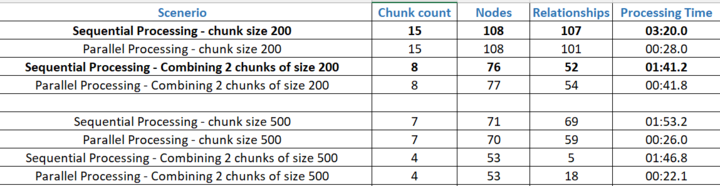